In [1]:
import os
import sys

sys.path.append("../")

from glob import glob
from argparse import ArgumentParser, Namespace

import numpy as np
import pandas as pd
import torch
import wandb
from omegaconf import DictConfig, OmegaConf
from rich.progress import track
from torch.utils.data import DataLoader

from src.dataset import preprocess, TrainAlphaDataset
from src.portfolio import PortfolioFormer
from src.trainer import Trainer
from src.model.nn_model import NeuralAlpha, AlphaSelfAttention
from src.model.loss import ICLoss
from src.utils.utils import dict2mat, seed_all, rolling

In [2]:
parser = ArgumentParser()
parser.add_argument("--symlink_path", type=str, default="data/symlink")
parser.add_argument("--gpuid", type=int, default=0)
parser.add_argument("--quick_expr", action="store_true")
parser.add_argument("--train_scale", type=int, default=250)
parser.add_argument("--look_back_window", type=int, default=60)
parser.add_argument("--direction", type=str, default="pos")
parser.add_argument("--label_type", type=str, default="cumret")
parser.add_argument("--future_window", type=int, default=5)
parser.add_argument("--wandb_track", action="store_true")
parser.add_argument("--n_epochs", type=int, default=50)
parser.add_argument("--batch_size", type=int, default=1)
parser.add_argument("--threshold", type=float, default=0.1)

args = parser.parse_args(
    "--symlink_path ../data/symlink "
    # "--quick_expr "
    "--train_scale 1061 "
    "--look_back_window 60 "
    "--direction pos "
    "--label_type cumret "
    "--future_window 20 "
    "--n_epochs 200 "
    "--batch_size 8 "
    "--threshold 0.05 ".split()
)
print(args.__dict__)

{'symlink_path': '../data/symlink', 'gpuid': 0, 'quick_expr': False, 'train_scale': 1061, 'look_back_window': 60, 'direction': 'pos', 'label_type': 'cumret', 'future_window': 20, 'wandb_track': False, 'n_epochs': 200, 'batch_size': 8, 'threshold': 0.05}


In [3]:
stock_conf = OmegaConf.load("../config/selected_stocks.yaml")
seed_all(2025)
folder_path = os.readlink(args.symlink_path)
device = f"cuda:{args.gpuid}" if torch.cuda.is_available() else "cpu"
stock = {}

for _, path in track(
    enumerate(glob(f"{folder_path}/*.csv")), description="Loading files..."
):
    curr_df = pd.read_csv(path)
    stock_name = os.path.basename(path).split(".")[0]

    if len(curr_df) >= 4000:
        stock[stock_name] = curr_df

if args.quick_expr:
    subset = {k: stock[k] for k in list(stock_conf.for_expr)}
else:
    subset = stock

shortest_sequence = min([len(v) for v in subset.values()])
preprocessed = preprocess(subset, args.label_type, args.future_window, args.direction)
first_train, test = dict2mat(preprocessed, args.train_scale, shortest_sequence)
first_train = np.transpose(first_train, (1, 0, 2))  # (days, stocks, features)
test = np.transpose(test, (1, 0, 2))  # (days, stocks, label)

tr_window_feat, tr_window_label = rolling(
    first_train, args.look_back_window
)  # (n_day - lbw, n_stocks, n_feat * lbw), (n_day - lbw, n_stocks, n_feat * lbw)
ts_window_feat, ts_window_label = rolling(test, args.look_back_window)
first_train_dataset = TrainAlphaDataset(tr_window_feat, tr_window_label)
first_train_loader = DataLoader(first_train_dataset, batch_size=args.batch_size, shuffle=True)

print("Data preparation complete")

model = NeuralAlpha(tr_window_feat.shape[-1], 128, 1, 0.1).to(device)
model = AlphaSelfAttention(
    input_dim=tr_window_feat.shape[-1],
    embed_dim=128,
    num_heads=1,
    dropout=0.1,
    kdim=None,
    vdim=None,
    device=device,
    dtype=torch.float32,
    value_weight_type="vanilla",
).to(device)

model_path = f"vanilla_attn_epoch_{args.n_epochs}_bs{args.batch_size}_tr_{args.train_scale}_lbw_{args.look_back_window}_fw_{args.future_window}{args.direction}{args.label_type}.pt"
criterion = ICLoss(ic_type="spearman")
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
trainer = Trainer(model, "attention", criterion, device, model_path)

train = False
if train:
    trainer.multi_asset_train(args.n_epochs, first_train_loader, optimizer)
else:
    model_type = "attention"
    model.load_state_dict(
        torch.load(
            f"../model/{model_path}",
            map_location=device,
        )
    )

    y_preds = []

    for i, (test_features, test_label) in track(enumerate(zip(ts_window_feat, ts_window_label))):
        if i % args.future_window == 0:
            if model_type == "attention":
                test_features, test_label = (
                    torch.tensor(test_features, dtype=torch.float32).unsqueeze(0),
                    torch.tensor(test_label, dtype=torch.float32).unsqueeze(0),
                )
            else:
                test_features, test_label = (
                    torch.tensor(test_features, dtype=torch.float32),
                    torch.tensor(test_label, dtype=torch.float32),
                )
            with torch.no_grad():
                model.train(False)
                y_pred = model(test_features)

            y_preds.append(y_pred[0, :, 0].cpu().numpy())



Output()

Output()

Data preparation complete


Output()

In [73]:
pf = PortfolioFormer(
    train_scale=args.train_scale,
    look_back_window=args.look_back_window,
    shortest_seq=shortest_sequence,
    future_window=args.future_window,
    num_stocks=len(subset)
)
lrf, srf, brf, prf = pf.form_portfolio(y_preds, subset, 30, 3)

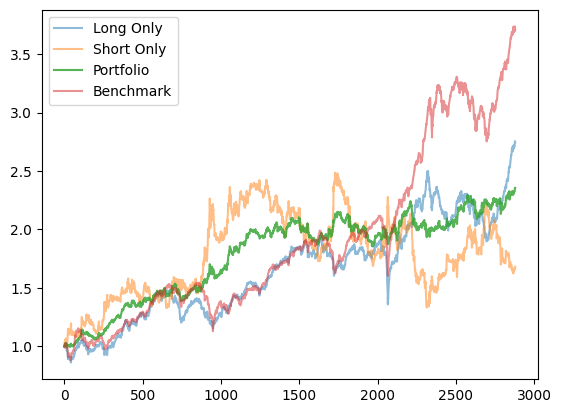

In [74]:
import matplotlib.pyplot as plt
plt.style.use("default")


plt.plot(np.cumprod(1 + lrf), label="Long Only", alpha=0.5)
plt.plot(np.cumprod(1 + srf), label="Short Only", alpha=0.5)
plt.plot(np.cumprod(1 + prf), label="Portfolio", alpha=0.8)
plt.plot(np.cumprod(1 + brf), label="Benchmark", alpha=0.5)
plt.legend()
plt.show()

In [59]:
class Metrics:
    def __init__(
        self, ret_sequence: list[np.ndarray]
    ) -> None:
        self.rets = ret_sequence

    def annual_ret(self, ret):
        return np.mean(ret) * 252

    def sharpe(self, ret):
        return (np.mean(ret) / np.std(ret)) * np.sqrt(252)

    def mdd(self, ret):
        cumsumret = ret.cumsum()
        running_max = np.maximum.accumulate(cumsumret)
        dd = cumsumret - running_max
        mdd = -1 * np.min(dd)

        return mdd

    def calmar(self, ret):
        return self.annual_ret(ret) / self.mdd(ret)

    def read(self, strats: list[str]):
        for i, ret in enumerate(self.rets):
            dic = {
                "annual return": self.annual_ret(ret),
                "annual sharpe": self.sharpe(ret),
                "mdd": self.mdd(ret),
                "calmar": self.calmar(ret)
            }
            print(f"{strats[i]} performance: {dic}")

In [75]:
met = Metrics([lrf, srf, prf, brf])
met.read(["Long Only", "Short Only", "Portfolio", "Benchmark"])

Long Only performance: {'annual return': 0.09453032364995473, 'annual sharpe': 0.851580087799877, 'mdd': 0.345899097544797, 'calmar': 0.27328872587680636}
Short Only performance: {'annual return': 0.06458999371559879, 'annual sharpe': 0.32962444325046664, 'mdd': 0.5743386404417066, 'calmar': 0.1124597740209932}
Portfolio performance: {'annual return': 0.07956015868277676, 'annual sharpe': 0.8311640318741248, 'mdd': 0.1453125805893426, 'calmar': 0.5475104657842116}
Benchmark performance: {'annual return': 0.11991338807740383, 'annual sharpe': 1.1847459624483179, 'mdd': 0.3083122666184127, 'calmar': 0.3889348594287895}
